In [ ]:
!pip install geopandas shapely pyproj folium contextily

In [14]:
# Imports
# Geometry
from shapely.geometry import Point, Polygon, LineString

# Visualization
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Patch
from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection
import folium
from IPython.display import display
import contextily as ctx

# Projections
import pyproj
from pyproj import CRS, Transformer

# Data
import geopandas as gpd
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np

# Network
import requests
import time

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define the Overpass API endpoint
endpoint = "https://overpass-api.de/api/interpreter"
# Define the latitude and longitude of the centroid if La Bota
lat_toctiuco = -0.20985476660321467
lon_toctiuco = -78.52568864705847
lat_bota = -0.11562405304648693
lon_bota = -78.45956887257326

In [4]:
# Define the Overpass API query --around 1000 meters
query = '[out:json][timeout:25];(way["highway"~"motorway|trunk|primary|secondary|tertiary|unclassified|residential|service|footway|pedestrian|track|cycleway|path"](around:1000,' + str(lat_toctiuco) + ',' + str(lon_toctiuco) + '););out geom;'

# Send the request to the Overpass API
response = requests.get(endpoint, params={'data': query})

# Convert the response to JSON format
data = response.json()['elements']

# Create a pandas DataFrame to store the data
df = pd.DataFrame(data)
# Extract values from the 'geometry' column and convert to LineString
geometry = [LineString([(d['lon'], d['lat']) for d in x]) for x in df['geometry']]
df['linestring'] = geometry

# Extract values from the 'tags' column and create new columns
df['alt_name'] = df['tags'].apply(lambda x: x['alt_name'] if 'alt_name' in x else None)
df['highway'] = df['tags'].apply(lambda x: x['highway'] if 'highway' in x else None)
df['name'] = df['tags'].apply(lambda x: x['name'] if 'name' in x else None)

# Drop the original 'tags' column
df.drop(columns=['tags', 'id', 'bounds', 'nodes', 'geometry'], inplace=True)

# Rename columns
df.rename(columns={'linestring': 'geometry'}, inplace=True)

#Make geodataframe
gdf_toctiuco = gpd.GeoDataFrame(df, geometry='geometry')

In [5]:
# Define the Overpass API query --around 1000 meters
query = '[out:json][timeout:25];(way["highway"~"motorway|trunk|primary|secondary|tertiary|unclassified|residential|service|footway|pedestrian|track|cycleway|path"](around:1000,' + str(lat_bota) + ',' + str(lon_bota) + '););out geom;'

# Send the request to the Overpass API
response = requests.get(endpoint, params={'data': query})

# Convert the response to JSON format
data = response.json()['elements']

# Create a pandas DataFrame to store the data
df = pd.DataFrame(data)
# Extract values from the 'geometry' column and convert to LineString
geometry = [LineString([(d['lon'], d['lat']) for d in x]) for x in df['geometry']]
df['linestring'] = geometry

# Extract values from the 'tags' column and create new columns
df['alt_name'] = df['tags'].apply(lambda x: x['alt_name'] if 'alt_name' in x else None)
df['highway'] = df['tags'].apply(lambda x: x['highway'] if 'highway' in x else None)
df['name'] = df['tags'].apply(lambda x: x['name'] if 'name' in x else None)

# Drop the original 'tags' column
df.drop(columns=['tags', 'id', 'bounds', 'nodes', 'geometry'], inplace=True)

# Rename columns
df.rename(columns={'linestring': 'geometry'}, inplace=True)

#Make geodataframe
gdf_bota = gpd.GeoDataFrame(df, geometry='geometry')

In [6]:
# Maps boundaries
def bounding_box_mercator(lat, lon, radius):
    # Define coordinate systems
    wgs84 = CRS("EPSG:4326")  # WGS84
    web_mercator = CRS("EPSG:3857")  # Web Mercator

    # Define transformer
    transformer = Transformer.from_crs(wgs84, web_mercator)

    # Transform lat lon to Web Mercator
    lon_mercator, lat_mercator = transformer.transform(lat, lon)

    # Add/subtract the radius from the projected point
    min_lat = lat_mercator - radius
    max_lat = lat_mercator + radius
    min_lon = lon_mercator - radius
    max_lon = lon_mercator + radius

    return min_lat, min_lon, max_lat, max_lon

# Radius
radius = 1500  # meters

min_lat_BOTA, min_lon_BOTA, max_lat_BOTA, max_lon_BOTA = bounding_box_mercator(lat_bota, lon_bota, radius)
min_lat_TOC, min_lon_TOC, max_lat_TOC, max_lon_TOC = bounding_box_mercator(lat_toctiuco, lon_toctiuco, radius)

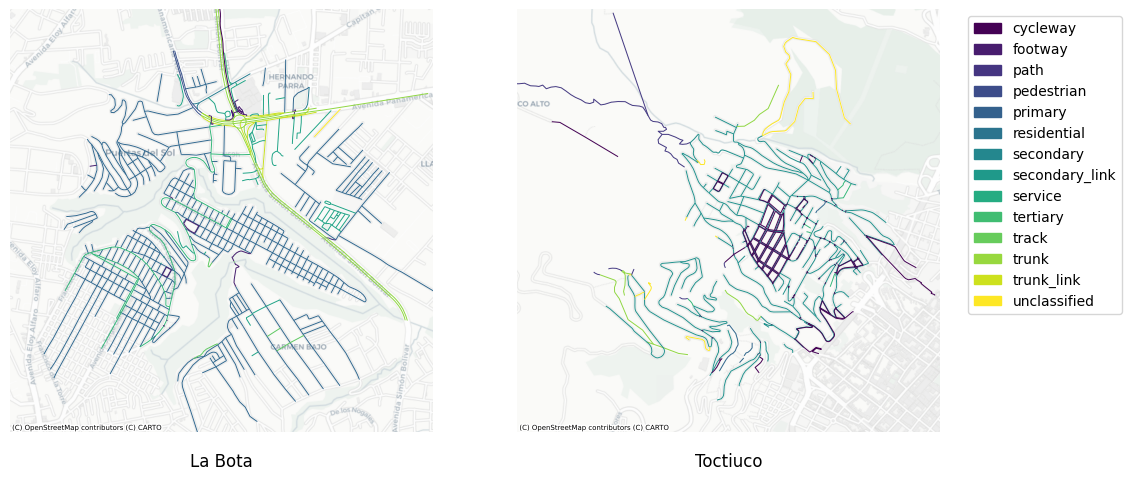

In [16]:
# Convert geodataframe to Web Mercator (epsg:3857)
gdf_bota.crs = "EPSG:4326"
gdf_bota2 = gdf_bota.to_crs(epsg=3857)
gdf_toctiuco.crs = "EPSG:4326"
gdf_toctiuco2 = gdf_toctiuco.to_crs(epsg=3857)

# Find the union of unique categories in both dataframes
all_roads = np.union1d(gdf_bota2['highway'].unique(), gdf_toctiuco2['highway'].unique())

# Create color mapping for each road type
colors = plt.get_cmap('viridis', len(all_roads))
color_dict = dict(zip(all_roads, colors.colors))

# Define the transformer from WGS84 to Web Mercator
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857")

# Create the first subplot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Subplot 1
ax = axs[0]

# Set the x and y axis limits
ax.set_xlim(min_lon_BOTA, max_lon_BOTA)
ax.set_ylim(min_lat_BOTA, max_lat_BOTA)

# Plot the data (only boundaries in this case)
gdf_bota2.plot(ax=ax, column='highway', linewidth=0.7, cmap='viridis')

# Add basemap with contextily
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, attribution_size=5)

# Get the updated x and y axis limits after adding the basemap
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.axis([xmin, xmax, ymin, ymax])

# Remove the axis
ax.axis('off')
ax.set_title('La Bota', loc='center', y=-0.1)

ax = axs[1]

# Set the x and y axis limits
ax.set_xlim(min_lon_TOC, max_lon_TOC)
ax.set_ylim(min_lat_TOC, max_lat_TOC)

# Plot the data (only boundaries in this case)
gdf_toctiuco2.plot(ax=ax, column='highway', linewidth=0.7, cmap='viridis')

# Add basemap with contextily
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, attribution_size=5)

# Get the updated x and y axis limits after adding the basemap
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.axis([xmin, xmax, ymin, ymax])

# Remove the axis
ax.axis('off')
ax.set_title('Toctiuco', loc='center', y=-0.1)

# Legend
patches = [Patch(color=color, label=road_type) for road_type, color in color_dict.items()]
ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)


In [19]:
# Save the figure in 300 dpi with tiff format
fig.savefig('/content/drive/MyDrive/Diversa/figures/ROADS.tiff', dpi=300, format='tiff', bbox_inches='tight')
fig.savefig('/content/drive/MyDrive/Diversa/figures/ROADS.jpg', dpi=300, format='jpeg', bbox_inches='tight')